# Visualisation de l'impact des paramètres de régularisation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

## Datasets

In [2]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=0, n_clusters_per_class=1
)
rng = np.random.RandomState(1)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

In [3]:
# Définir le cubique séparant les classes
def cubic(x):
    return x**3 + x**2 - 4*x + 3

num_points = 100
x = np.random.uniform(-5, 5, size=num_points)
y = np.random.uniform(-10, 20, size=num_points)

# Attribuer des étiquettes en fonction du cubique
labels = (y > cubic(x)).astype(int)

# Ajouter du bruit aux étiquettes
noise_level = 0.5
noise = np.random.uniform(size=num_points)
# labels = (1 - noise_level) * labels + noise_level * noise

new_X = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

cubic_data = (new_X, labels)

In [4]:
# Définir le nombre de points de données
N = 100

# Définir les deux bras spiraux
theta = np.sqrt(np.random.rand(N)) * 2 * np.pi  # angle
r_a = 2 * theta + np.pi + 2*np.random.rand(N) # radius for arm a
data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
r_b = -2 * theta - np.pi + 2*np.random.rand(N) # radius for arm b
data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T

# Concaténer les deux bras
data = np.concatenate((data_a, data_b))

# Créer les étiquettes cibles
labels = np.concatenate((np.ones(N), np.zeros(N))).astype(int)

# Mélanger les données et les étiquettes à l'unisson
indices = np.random.permutation(N * 2)
data, labels = data[indices], labels[indices]
dataset_d = (data, labels)

In [5]:
n_samples = 100

datasets = [
    make_circles(n_samples=n_samples, factor=0.5, noise=0.08),
    make_moons(n_samples=n_samples, noise=0.08),
    cubic_data, 
    dataset_d,
    linearly_separable,
]

## Classificateurs

In [6]:
alphas =  [0, 0.1, 1, 10, 100]

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(
        make_pipeline(
            StandardScaler(),
            MLPClassifier(
                solver="lbfgs",
                alpha=alpha,
                random_state=1,
                max_iter=2000,
                early_stopping=True,
                hidden_layer_sizes=[10, 10],
            ),
        )
    )
    names.append(f"$\\lambda = $ {alpha:.2f}")

## Graphique

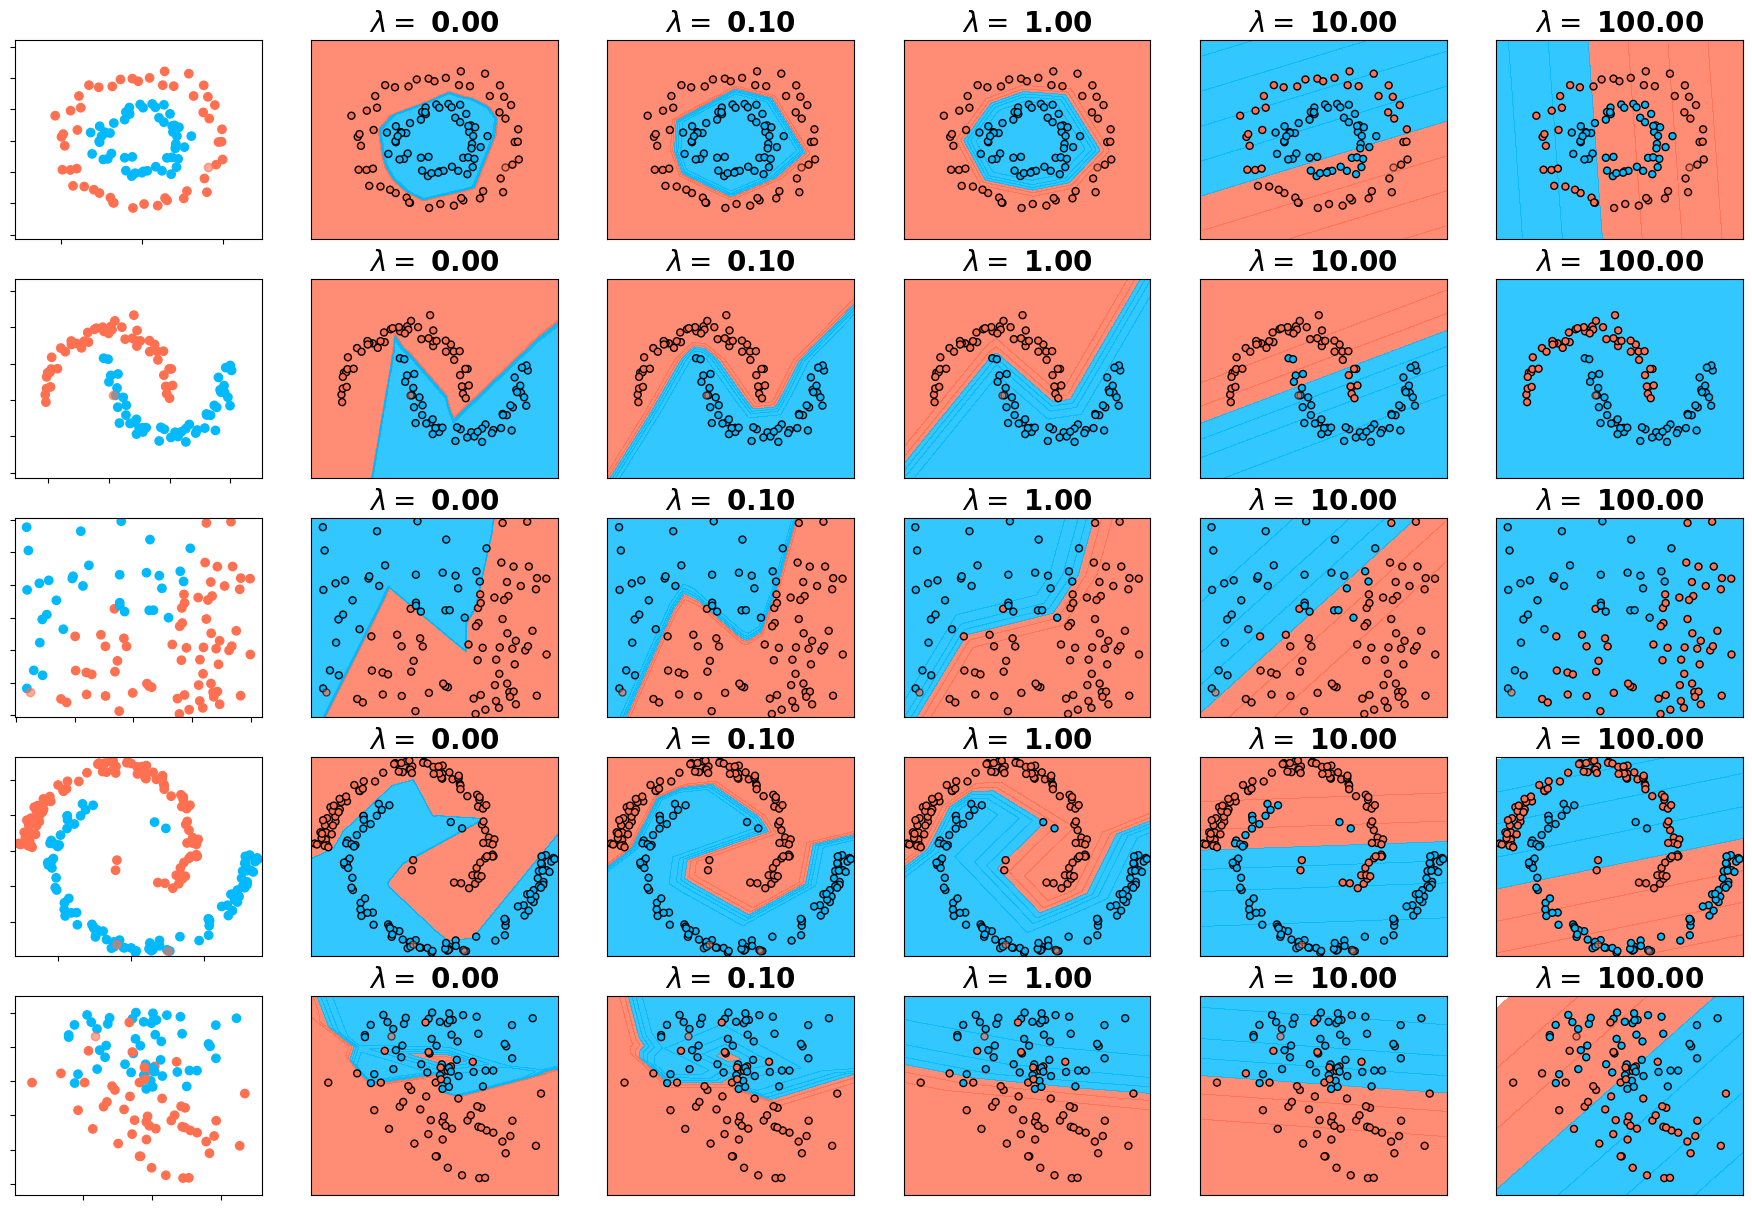

In [7]:
figure = plt.figure(figsize=(18, 15))
i = 1

for X, y in datasets:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.01, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02 ), np.arange(y_min, y_max, 0.02))

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF7051", "#00B9FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    i += 1

    # itérer sur les classificateurs
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Tracer la frontière de décision. Pour cela, nous allons attribuer une couleur 
        # à chaque point du maillage [x_min, x_max] x [y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
        else:
            Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Placer le résultat dans un graphique en couleur
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=0.8)

        # Tracer également les points d'entraînement
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cm_bright,
            edgecolors="black",
            s=25,
        )
        # et les points de test
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            alpha=0.6,
            edgecolors="black",
            s=25,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name, fontsize=20, fontweight="bold")
        i += 1

figure.subplots_adjust(left=0.02, right=0.98)
plt.show()

In [8]:
clf[-1].coefs_[0]

array([[ 8.35476806e-06, -1.29066987e-05,  1.49535843e-05,
         8.43964067e-06,  5.46943218e-06,  1.18557175e-05,
         1.01037005e-05,  3.70503012e-06,  2.12142850e-06,
        -9.78452613e-06],
       [-1.35980250e-05,  1.52132934e-05,  3.30938991e-06,
         7.41538247e-07,  1.68626879e-05,  1.14315983e-05,
         6.64292409e-07, -1.40798113e-06,  1.31551207e-05,
         2.52379486e-05]])